# Unsupervised surgery pipeline with interpetable autoencoder EXPIMAP

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

Global seed set to 0


In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download reference and do preprocessing

In [ ]:
url = 'https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0'
output = 'pbmc_tutorial.h5ad'
gdown.download(url, output, quiet=False)

In [4]:
adata = sc.read('pbmc_tutorial.h5ad')

`.X` should contain raw counts.

In [5]:
adata.X = adata.layers["counts"].copy()

Read Reactome annotations into the reference dataset, the binary matrix of annotation is in `adata.varm['I']`.

In [ ]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

In [6]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

Remove all genes which are not present in the Reactome annotations.

In [7]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

For a better model performance it is necessary to select HVGs. We are doing this by applying the `scanpy.pp` function `highly_variable_genes()`. The `n_top_genes` is set to 2000 here. Howeever, if you more complicated datasets you might have to increase number of genes to capture more diversity in the data.

In [8]:
sc.pp.normalize_total(adata)

In [9]:
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

Filter out all annotations which has the number of genes lower than 12.

In [11]:
select_terms = adata.varm['I'].sum(0)>12

In [12]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [13]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out unannotated genes again.

In [14]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

Put count back to `adata.X`.

In [15]:
adata.X = adata.layers["counts"].copy()

## Example without extension nodes in the query

### Create EXPIMAP model and train it on reference dataset

In [16]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  282 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


Set the `alpha` hyperparameter, it regulates the strength of group lasso regularization of annotations (terms). Higher value means that higher number of latent variables corresponding to annotations will be deactivated during training depending on their contribution to the reconstruction loss.

In [30]:
ALPHA = 0.7

In [18]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Init the group lasso proximal operator for the main terms.
 |████████------------| 41.8%  - epoch_loss: 875.0875513335 - epoch_recon_loss: 849.8969689248 - epoch_kl_loss: 50.3811637679 - val_loss: 938.5590139536 - val_recon_loss: 912.9722806490 - val_kl_loss: 51.17346543531427418
ADJUSTED LR
 |█████████-----------| 46.0%  - epoch_loss: 867.2534920638 - epoch_recon_loss: 842.2286955321 - epoch_kl_loss: 50.0495922638 - val_loss: 939.3953810472 - val_recon_loss: 913.6503906250 - val_kl_loss: 51.4899893541
ADJUSTED LR
 |██████████----------| 50.5%  - epoch_loss: 868.1691942506 - epoch_recon_loss: 843.1531918455 - epoch_kl_loss: 50.0320032611 - val_loss: 937.6233802209 - val_recon_loss: 911.8207420936 - val_kl_loss: 51.6052835905
ADJUSTED LR
 |████████████--------| 60.2%  - epoch_loss: 874.0884924476 - epoch_recon_loss: 848.9184943453 - epoch_kl_loss: 50.3399958715 - val_loss: 938.2763272799 - val_recon_loss: 912.5495535044 - val_kl_loss: 51.4535569411
ADJUSTED LR
 |████████████--------| 63

In [16]:
MEAN = False

Plot the latent space of the reference.

In [20]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [21]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [22]:
sc.tl.umap(adata)

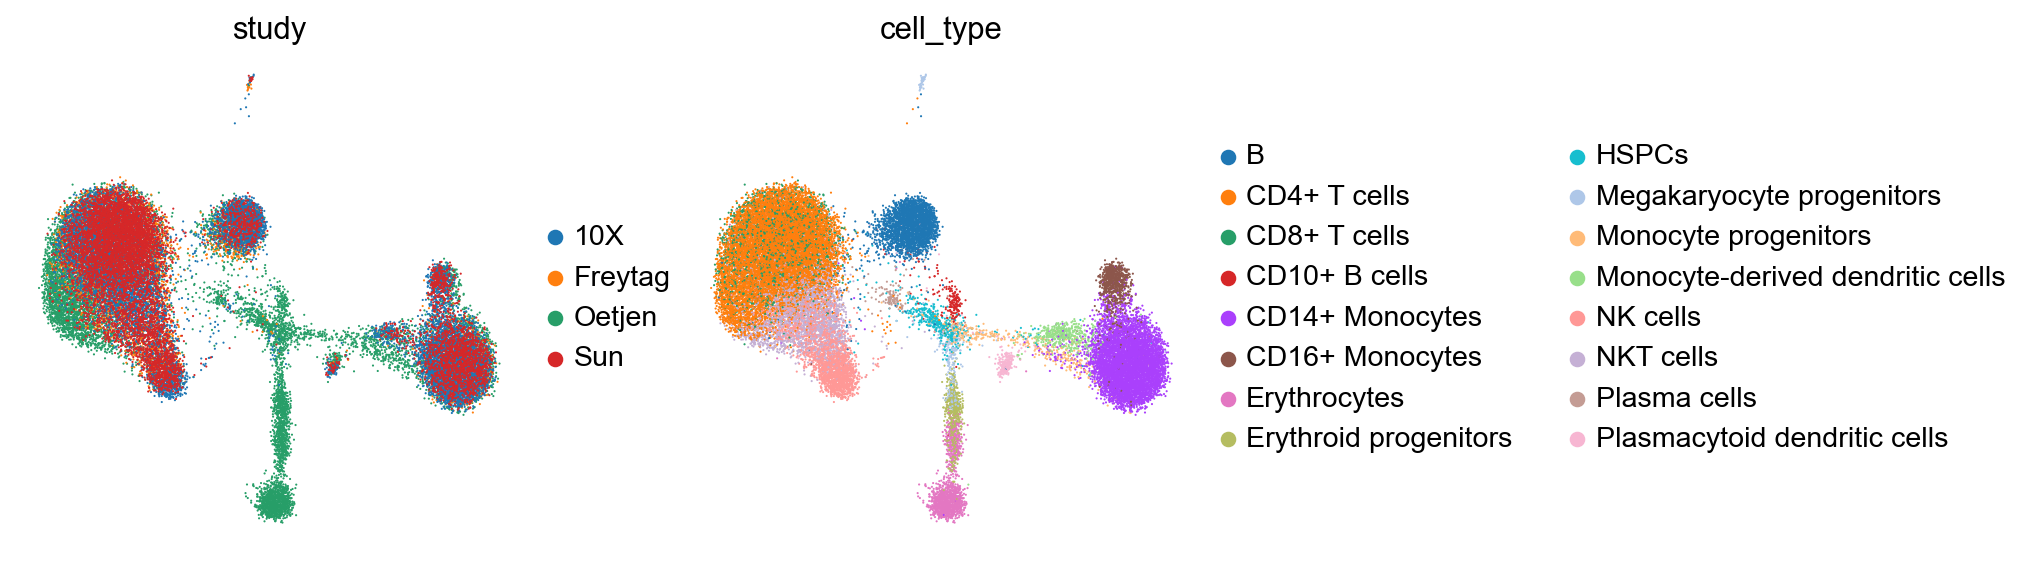

In [23]:
sc.pl.umap(adata, color=['study', 'cell_type'], frameon=False)

### Download query and do surgery

In [ ]:
url = 'https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG'
output = 'kang_tutorial.h5ad'
gdown.download(url, output, quiet=False)

In [17]:
kang = sc.read('kang_tutorial.h5ad')[:, adata.var_names].copy()

In [18]:
kang.obs['study'] = 'Kang'

In [19]:
kang.uns['terms'] = adata.uns['terms']

In [27]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  282 0 0 5 1972
	with hard mask.
Last Decoder layer: softmax


In [28]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

 |████████------------| 41.2%  - val_loss: 519.4205793901 - val_recon_loss: 512.4798778187 - val_kl_loss: 69.40706010300
ADJUSTED LR
 |████████------------| 43.0%  - val_loss: 520.2541309703 - val_recon_loss: 513.2979486639 - val_kl_loss: 69.5618133545
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 150


Save your model.

In [ ]:
q_intr_cvae.save('query_kang_tutorial')

In [29]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN, only_active=True)

Plot the latent space of the query.

In [30]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [31]:
sc.tl.umap(kang)

... storing 'study' as categorical


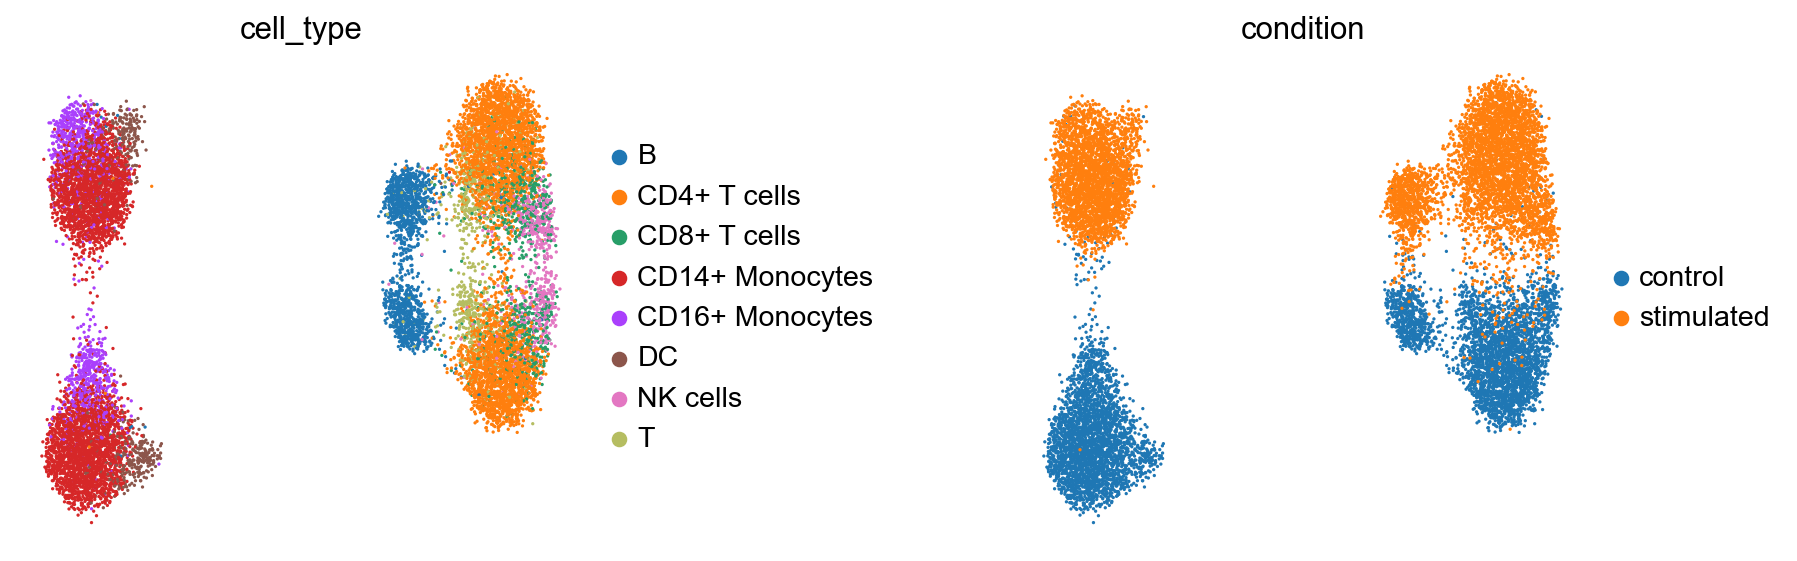

In [32]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

### Get latent representation of reference + query dataset

In [33]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join', uns_merge='same')

In [34]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN, only_active=True)

In [35]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [36]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs.condition.astype(str)
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].astype(str)=='nan']='control'

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'cell_type' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'condition_joint' as categorical


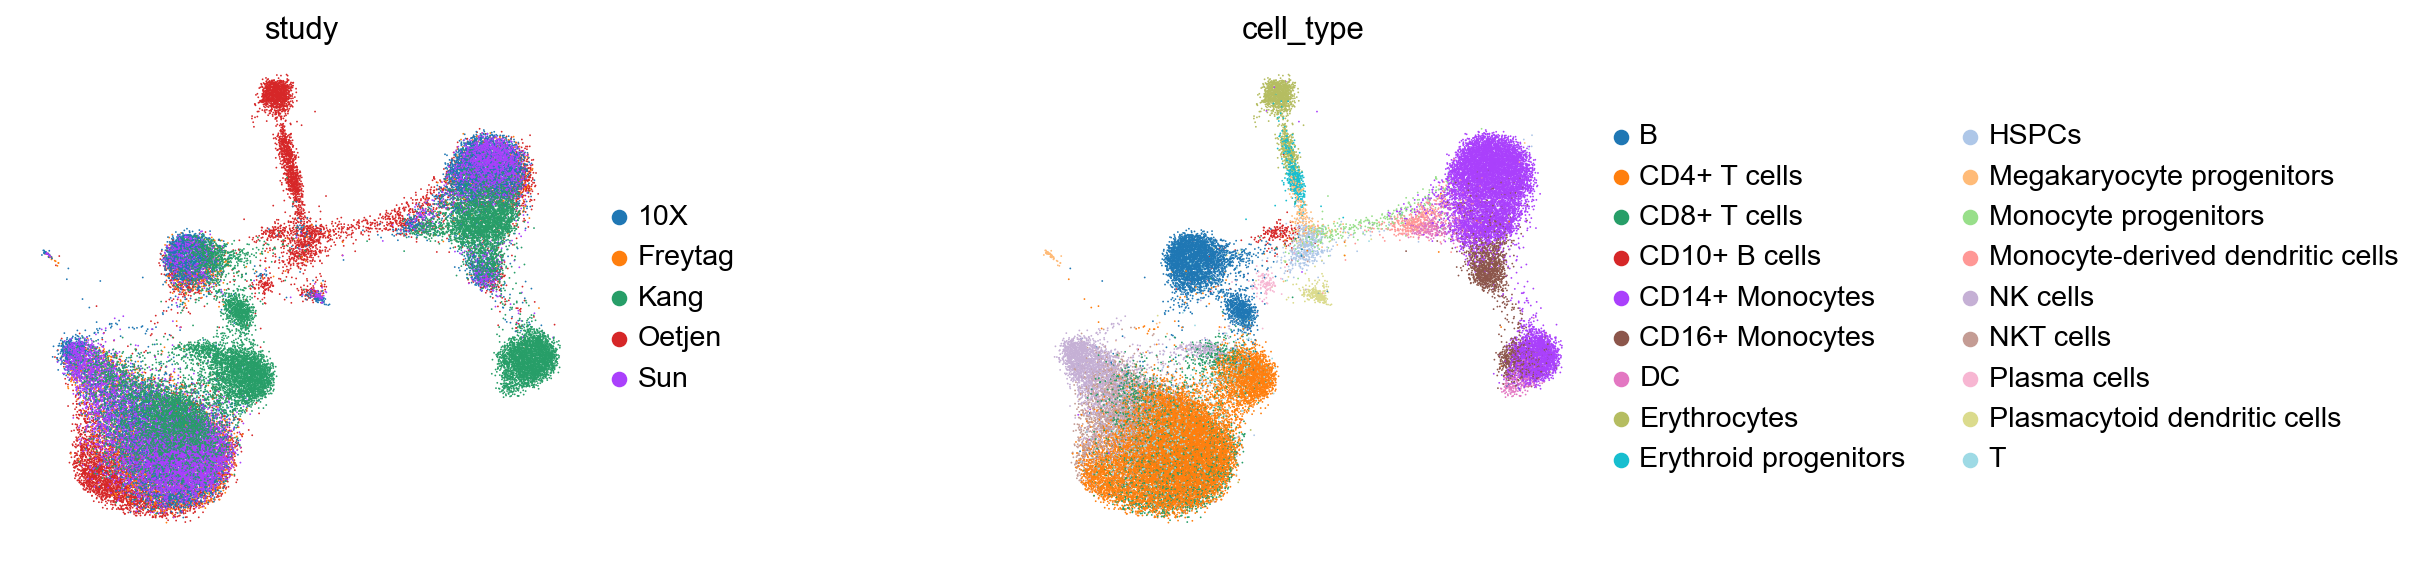

In [37]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type'], frameon=False, wspace=0.6)

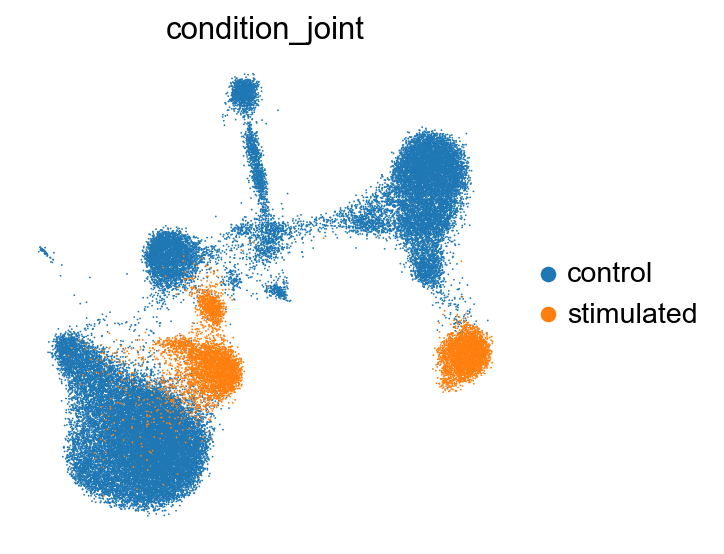

In [38]:
sc.pl.umap(kang_pbmc, color='condition_joint', frameon=False, wspace=0.6)

Calculate directions of upregulation for each latent score and put them to `kang_pbmc.uns['directions']`.

In [39]:
q_intr_cvae.latent_directions(adata=kang_pbmc)

Do gene set enrichment test for condition in reference + query.

In [40]:
q_intr_cvae.latent_enrich(groups='condition_joint', comparison='control', use_directions=True, adata=kang_pbmc)

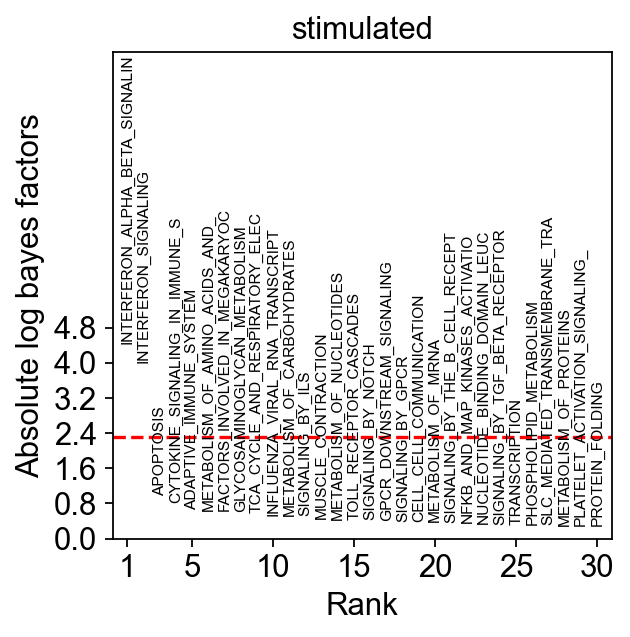

In [41]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc, yt_step=0.8, scale_y=2.5, fontsize=7)

Plot the latent variables for query + reference corresponding to the annotations 'INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPTOR', 'INTERFERON_ALPHA_BETA_SIGNALING'.

In [42]:
terms = kang_pbmc.uns['terms']
select_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN', 'SIGNALING_BY_THE_B_CELL_RECEPT']
idx = [terms.index(term) for term in select_terms]

Multiplying the latent varibales by the calculated directons to ensure positive latent scores corresponf to upregulation. 

In [43]:
latents = (q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN) * kang_pbmc.uns['directions'])[:, idx]

In [44]:
kang_pbmc.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang_pbmc.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 1]

kang_pbmc.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 2]

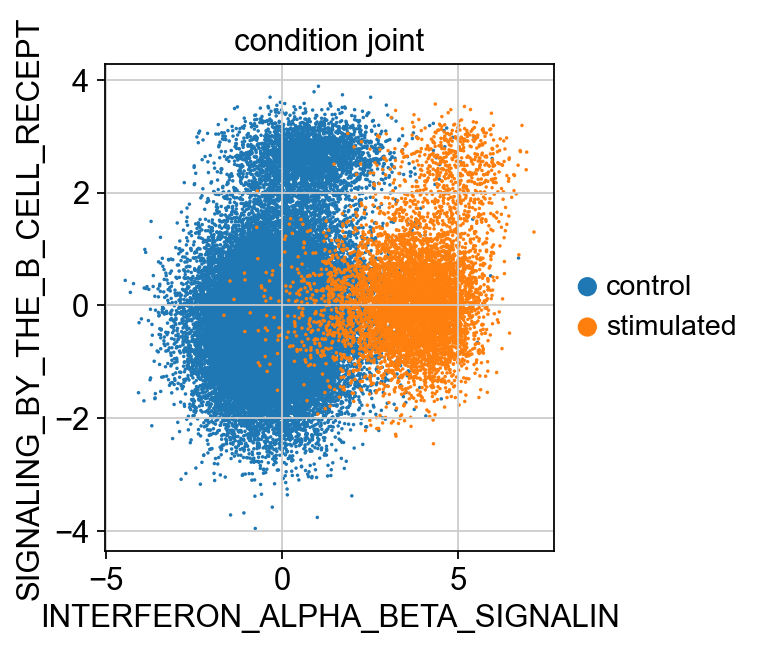

In [45]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition_joint', size=10)

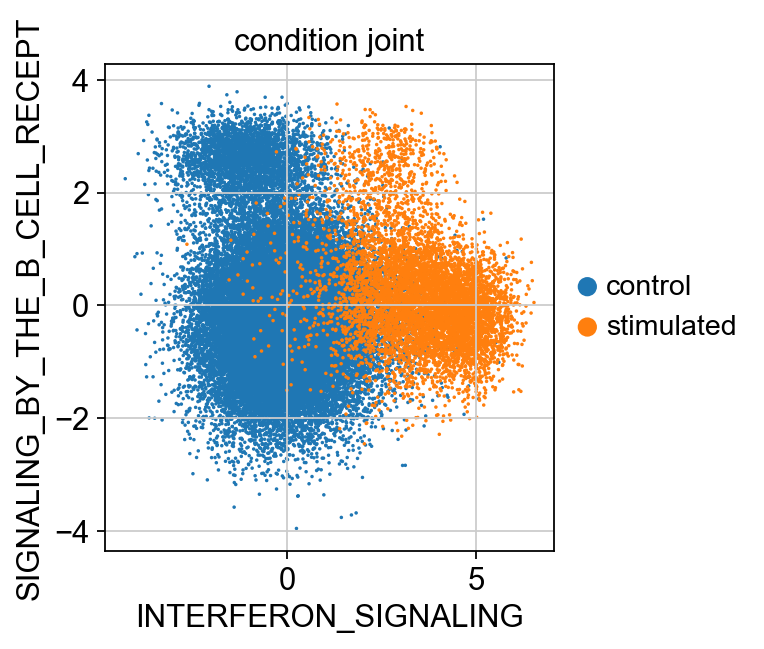

In [46]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition_joint', size=10)

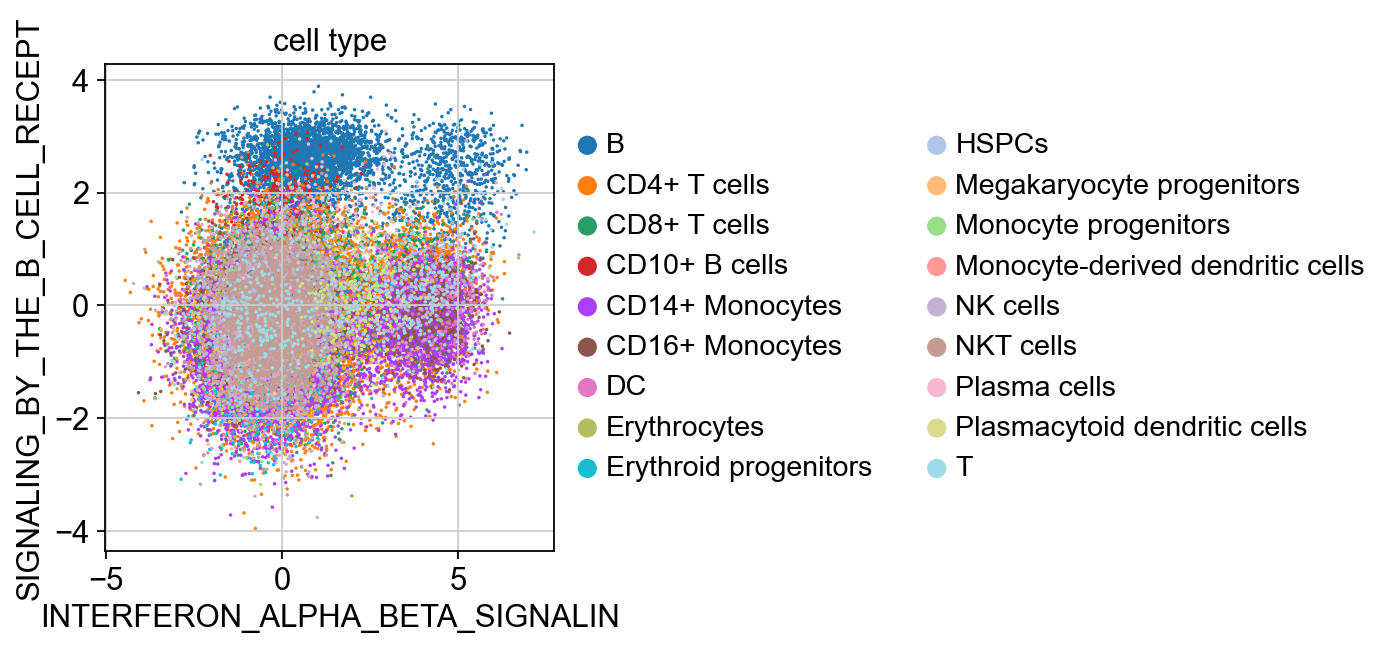

In [47]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type', size=10)

## Example with constrained and unconstrained extension nodes

Remove signal from the reference. It will be recovered with extension nodes added in the query.

Select the interferon annotations from the loaded Reactome pathway database for removal.

In [20]:
rm_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN',
            'CYTOKINE_SIGNALING_IN_IMMUNE_S', 'ANTIVIRAL_MECHANISM_BY_IFN_STI']

Select the annotations related to B cells for removal.

In [21]:
rm_terms += ['SIGNALING_BY_THE_B_CELL_RECEPT', 'MHC_CLASS_II_ANTIGEN_PRESENTAT']

In [22]:
ix_f = []
for t in rm_terms:
    ix_f.append(adata.uns['terms'].index(t))

Store the 'SIGNALING_BY_THE_B_CELL_RECEPT' annotation separately.

In [23]:
query_mask = adata.varm['I'][:, ix_f[4]][:, None].copy()

Remove the selected annotations.

In [24]:
adata.varm['I'] = np.delete(adata.varm['I'], ix_f, axis=1)

In [25]:
adata.uns['terms'] = [term for term in adata.uns['terms'] if term not in rm_terms]

Remove B cells from the reference.

In [26]:
rm_b = ["B", "CD10+ B cells"]

In [27]:
adata = adata[~adata.obs['cell_type'].isin(rm_b)].copy()

### Train the reference again.

In [28]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[300, 300, 300],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 4
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 276
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  276 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


In [31]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - val_loss: 937.1711611540 - val_recon_loss: 910.8452944548 - val_kl_loss: 52.651730910608
Saving best state of network...
Best State was in Epoch 196


### Do surgery using the extension nodes.

In [32]:
kang.uns['terms'] = adata.uns['terms']

Add one constrained with the 'SIGNALING_BY_THE_B_CELL_RECEPT' annotation and 3 unconstrained nodes. Also use HSIC regularization for the unconstrained nodes.

In [33]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(kang, intr_cvae,
                                                 unfreeze_ext=True,
                                                 new_n_ext=3,
                                                 new_n_ext_m=1,
                                                 new_ext_mask=query_mask.T,
                                                 new_soft_ext_mask=True,
                                                 use_hsic=True,
                                                 hsic_one_vs_all=True
                                                )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 5
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 276
	Expanded Mean/Var Layer in/out: 300 4
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  276 1 3 5 1972
	with hard mask.
Last Decoder layer: softmax


Train with hypeparameters:

`gamma_ext` - L1 regularization coefficient for the new unconstrained nodes. Specifies the strength of sparcity enforcement for these nodes.

`gamma_epoch_anneal` - number of epochs for `gamma_ext` annealing.

`alpha_l1` - L1 regularization coefficient for the soft mask of the new constrained node.

`beta` - HSIC regularization coefficient for the unconstrained nodes, enforces their independence from the old reference nodes and from each other if `hsic_one_vs_all=True`.

In [60]:
q_intr_cvae.train(
    n_epochs=150, 
    alpha_epoch_anneal=50,
    alpha_kl=0.1,
    weight_decay=0., 
    alpha_l1=0.94,
    gamma_ext=0.7,
    gamma_epoch_anneal=50,
    beta=3.,
    seed=2020,
    use_early_stopping=False
)

Init the L1 proximal operator for the unannotated extension.
Init the soft mask proximal operator for the annotated extension.
 |████████████████████| 100.0%  - val_hsic_loss: 0.2188439464 - val_loss: 520.3820523349 - val_recon_loss: 508.7906716087 - val_kl_loss: 109.3484510942


In [34]:
q_intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=80,
    alpha_kl=0.1,
    weight_decay=0., 
    alpha_l1=0.95,
    gamma_ext=0.7,
    gamma_epoch_anneal=50,
    beta=3.,
    seed=2020,
    use_early_stopping=False
)

Init the L1 proximal operator for the unannotated extension.
Init the soft mask proximal operator for the annotated extension.
 |████████████████████| 100.0%  - val_hsic_loss: 0.2271666622 - val_loss: 512.1002613414 - val_recon_loss: 500.7366277521 - val_kl_loss: 106.8212946112


### Analysis of the extension nodes for reference + query dataset

In [35]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join', uns_merge='same')

In [36]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs.condition.astype(str)
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].astype(str)=='nan']='control'

This adds extension nodes' names to `kang_pbmc.uns['terms']`.

In [37]:
q_intr_cvae.update_terms(adata=kang_pbmc)

In [38]:
q_intr_cvae.latent_directions(adata=kang_pbmc)

Do gene set enrichment test for condition in reference + query.

In [39]:
q_intr_cvae.latent_enrich(groups='condition_joint', comparison='control', use_directions=True, adata=kang_pbmc)

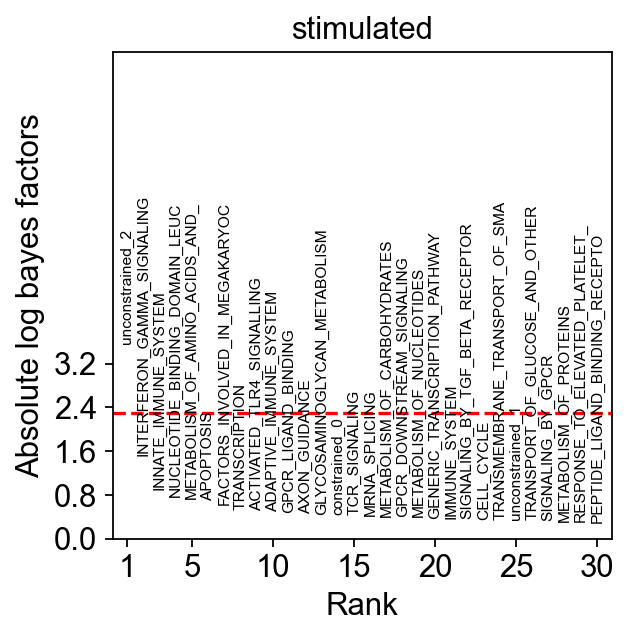

In [40]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc, yt_step=0.8, scale_y=2.5, fontsize=7)

Do gene set enrichment test for cell types in reference + query control.

In [41]:
kang_pbmc_control = kang_pbmc[kang_pbmc.obs['condition_joint']=='control'].copy()

q_intr_cvae.latent_enrich(groups='cell_type', use_directions=True, adata=kang_pbmc_control, n_sample=10000)

In [ ]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc_control, n_cols=3, scale_y=2.6, yt_step=0.6)

In [43]:
fig.set_size_inches(16, 34)

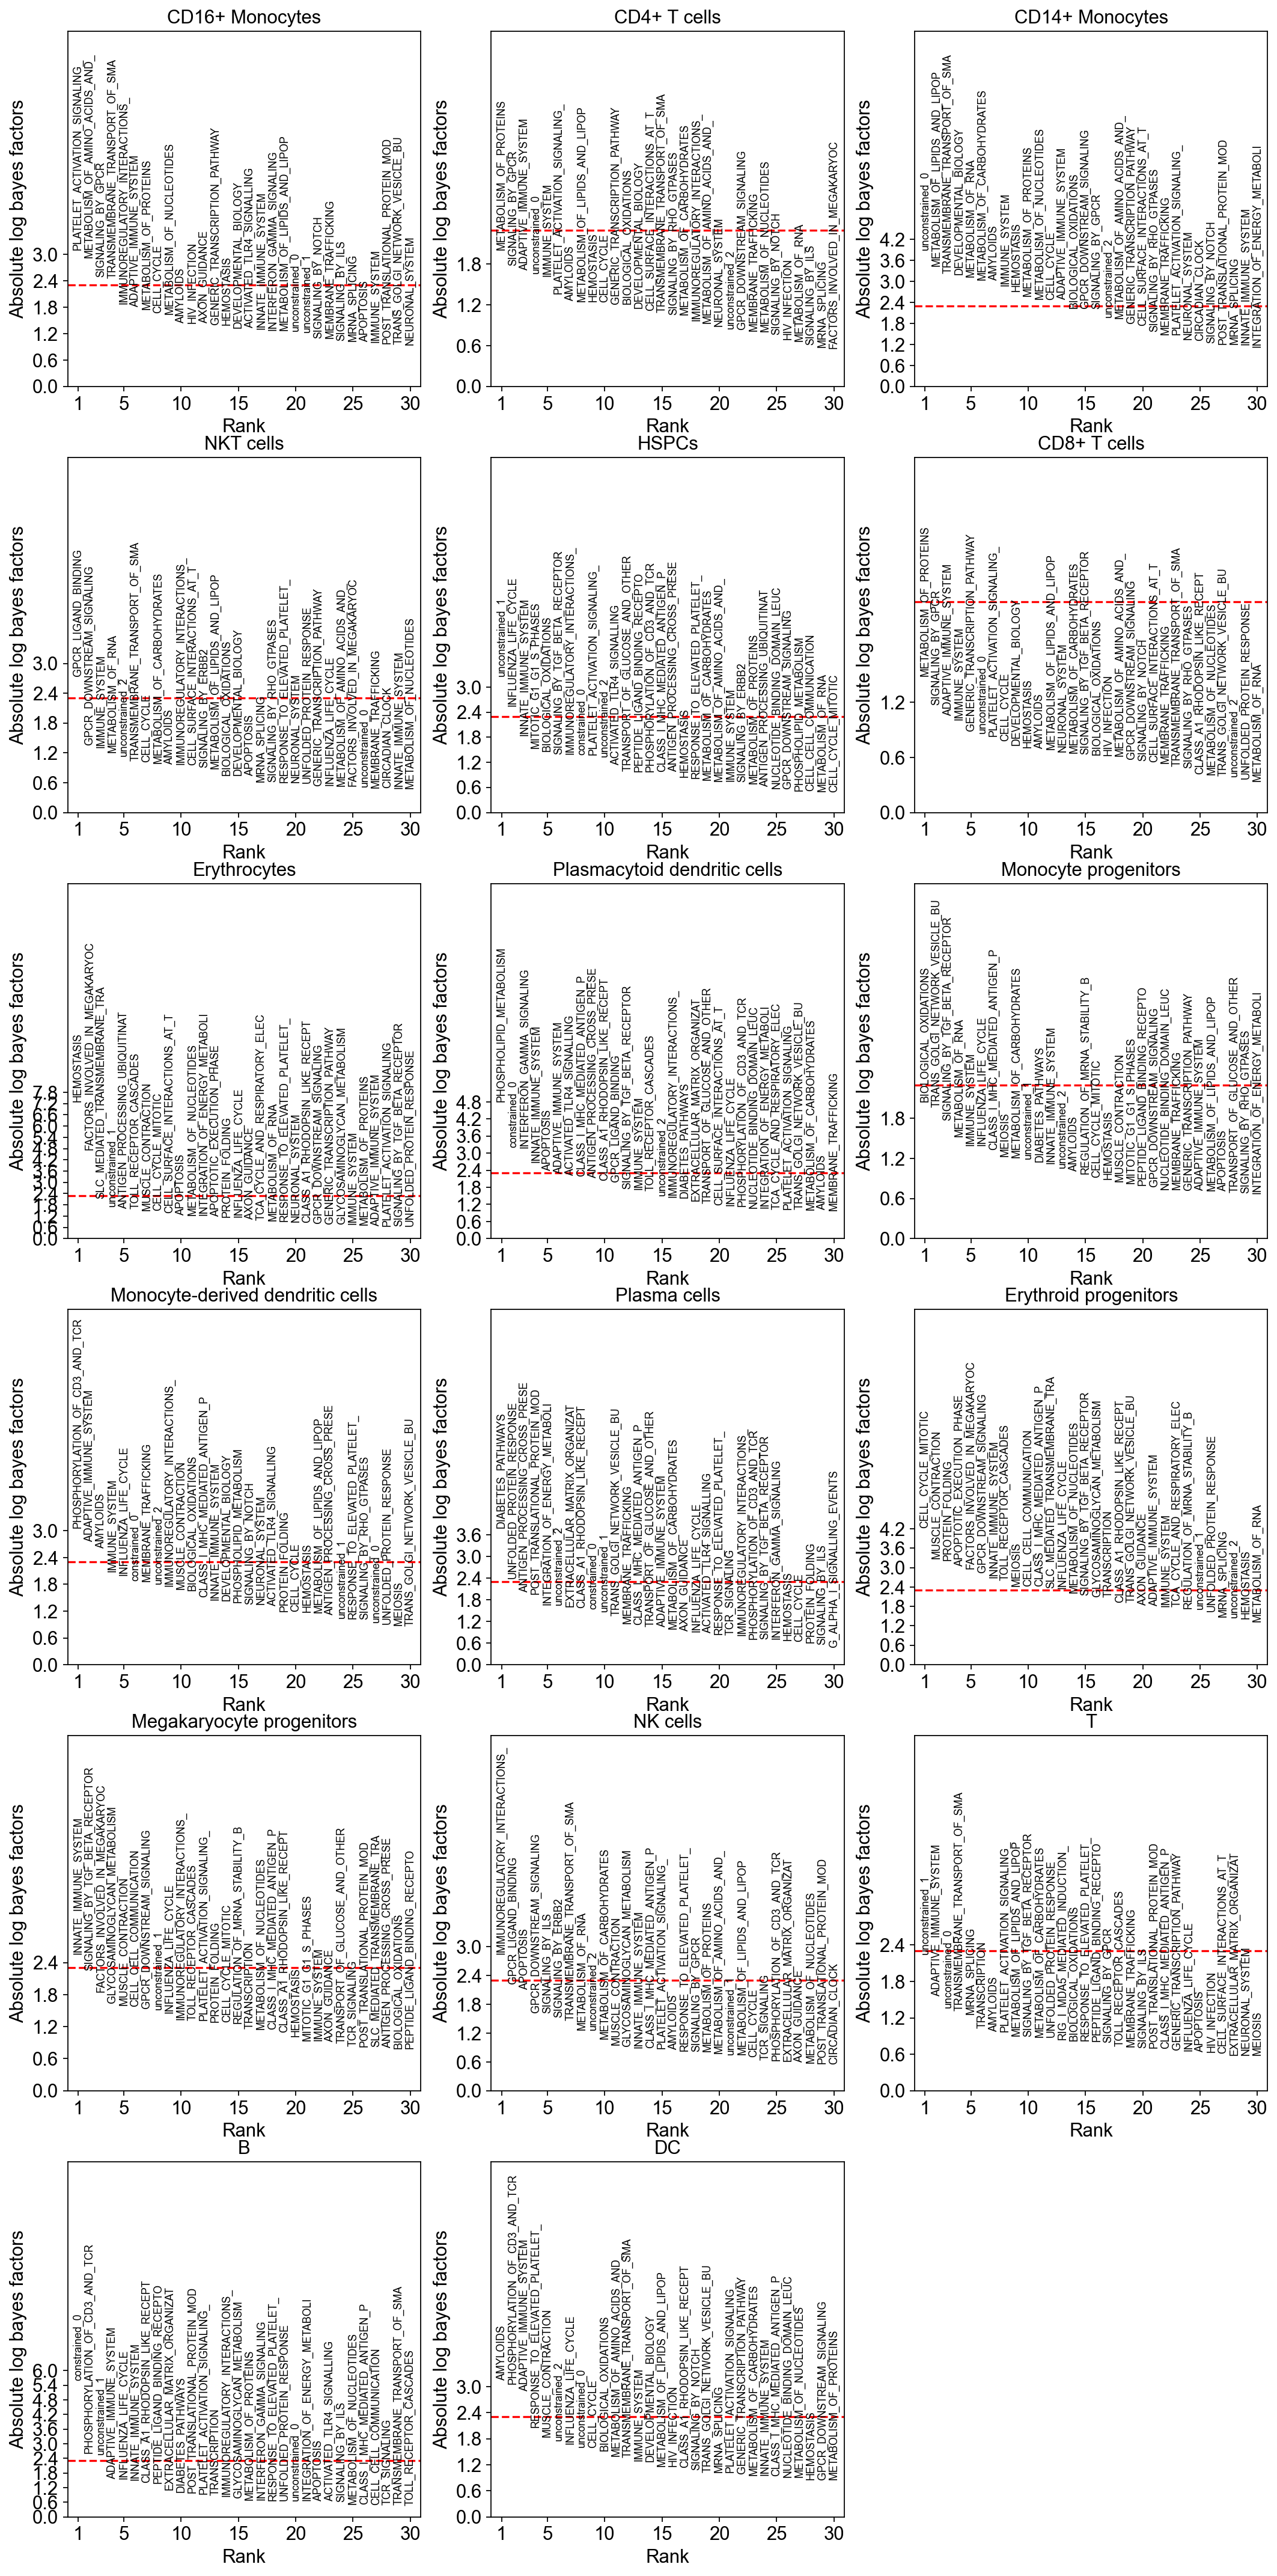

In [44]:
fig

Plot the latent variables for query + reference corresponding to the constrained and unconstrained extension nodes.

In [45]:
terms = kang_pbmc.uns['terms']
select_terms = ['constrained_0', 'unconstrained_0', 'unconstrained_1', 'unconstrained_2']
idx = [terms.index(term) for term in select_terms]

In [46]:
latents = (q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN) * kang_pbmc.uns['directions'])[:, idx]

In [47]:
kang_pbmc.obs['constrained_0'] = latents[:, 0]

kang_pbmc.obs['unconstrained_0'] = latents[:, 1]
kang_pbmc.obs['unconstrained_1'] = latents[:, 2]
kang_pbmc.obs['unconstrained_2'] = latents[:, 3]

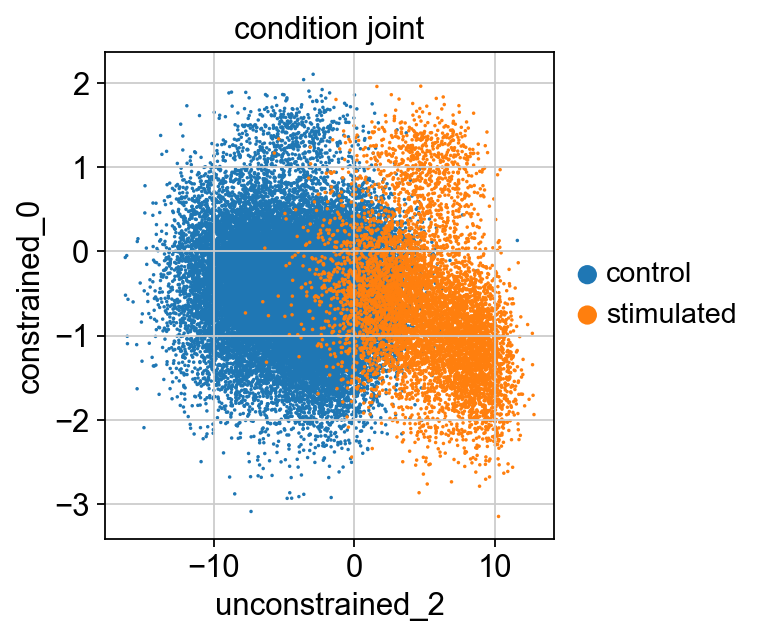

In [68]:
sc.pl.scatter(kang_pbmc, x='unconstrained_2', y='constrained_0', color='condition_joint', size=10)

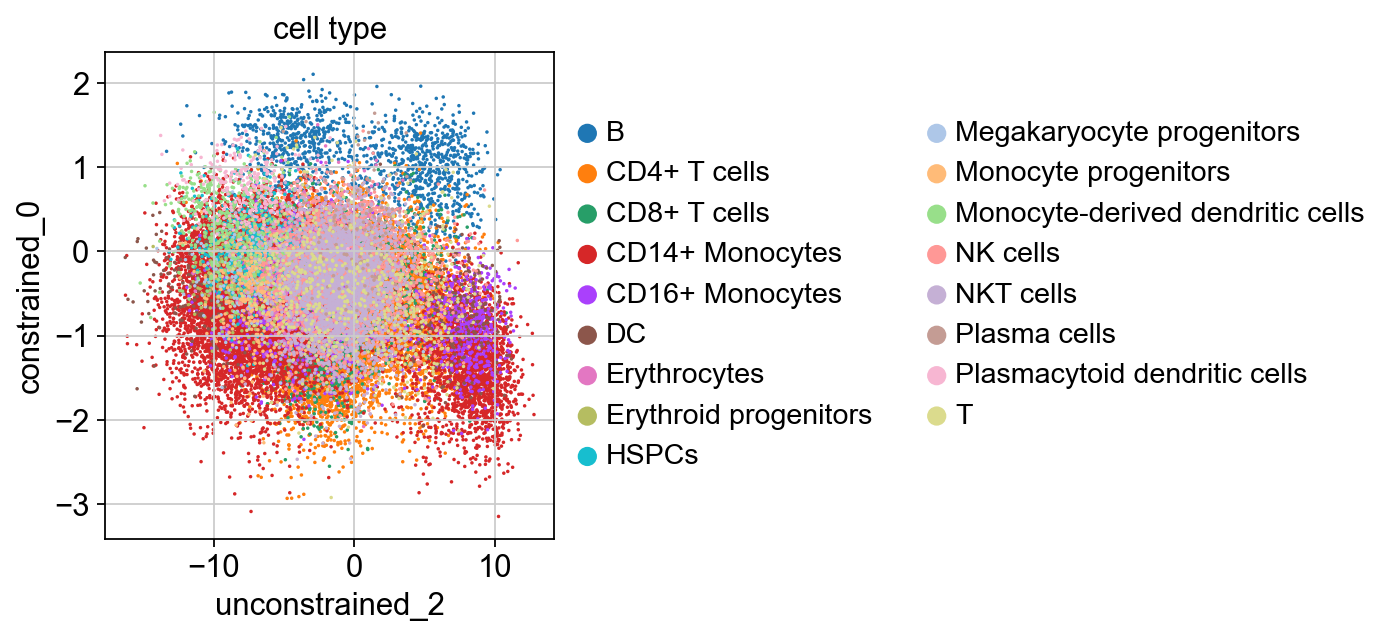

In [69]:
sc.pl.scatter(kang_pbmc, x='unconstrained_2', y='constrained_0', color='cell_type', size=10)

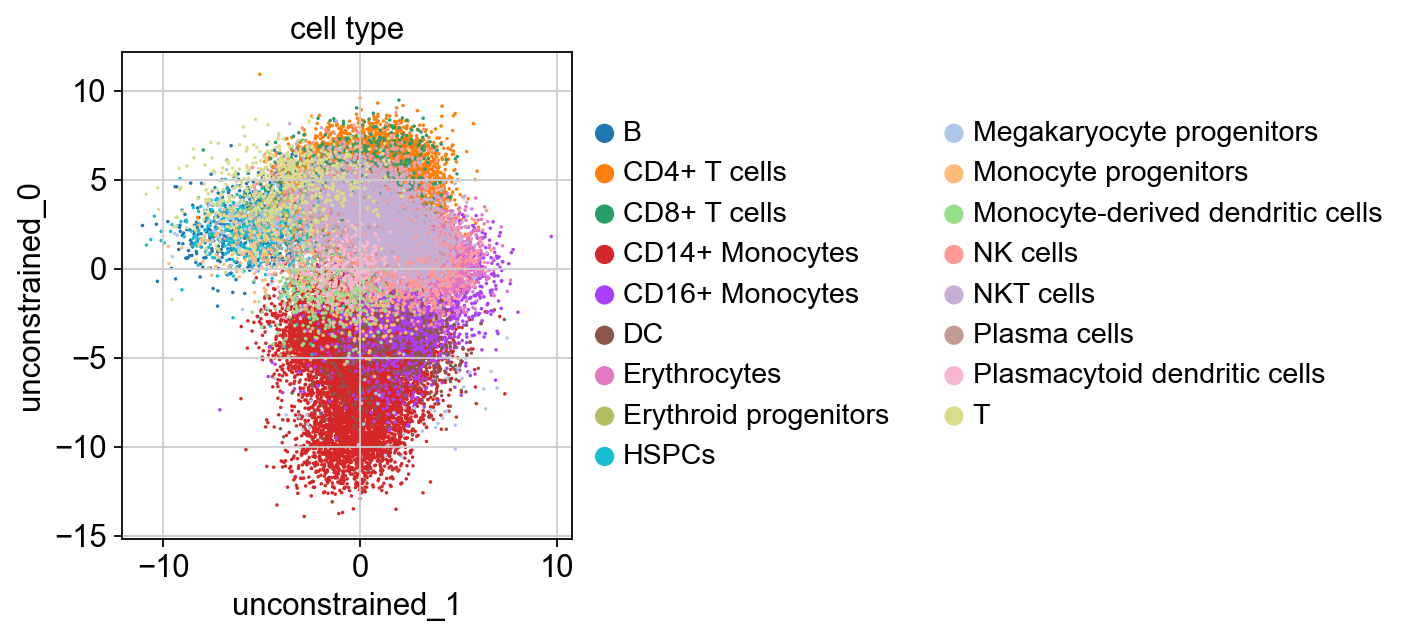

In [71]:
sc.pl.scatter(kang_pbmc, x='unconstrained_1', y='unconstrained_0', color='cell_type', size=10)

Get genes from extension nodes sorted by their absolute weights in the decoder

In [51]:
q_intr_cvae.term_genes('constrained_0', terms=kang_pbmc.uns['terms'])

genes   weights  in_mask
0     CD79A  2.577576     True
1       BLK  2.444428     True
2      CD19  2.443115     True
3     CD79B  1.897685     True
4      BLNK  1.815371     True
..      ...       ...      ...
63  SH3KBP1 -0.011071     True
64    PSME4  0.008827     True
65    PDPK1 -0.003309     True
66     AKT1 -0.001834     True
67    RPS12 -0.000431    False

[68 rows x 3 columns]

In [52]:
q_intr_cvae.term_genes('unconstrained_0', terms=kang_pbmc.uns['terms'])

genes       weights  in_mask
0       RGS2  2.600274e-01    False
1       CCL2 -2.372731e-01    False
2     PLA2G7 -2.057227e-01    False
3      TIMP1 -2.047525e-01    False
4       GMPR -1.461783e-01    False
..       ...           ...      ...
474    GNGT2  6.676884e-06    False
475  PIP4K2A -6.051618e-06    False
476     WSB1  5.175360e-06    False
477    GSPT2  1.665554e-06    False
478     DFFA  6.342307e-07    False

[479 rows x 3 columns]

In [63]:
q_intr_cvae.term_genes('unconstrained_2', terms=kang_pbmc.uns['terms'])

genes       weights  in_mask
0     IFIT3  2.393449e-01    False
1     IFIT2  2.369517e-01    False
2     IFIT1  2.357078e-01    False
3     ISG15  2.267355e-01    False
4     IL1RN  2.248791e-01    False
..      ...           ...      ...
396    LRP8  3.038265e-06    False
397  ACTR1B -2.848858e-06    False
398   EXOC6  2.657005e-06    False
399   FURIN -2.656190e-06    False
400    PAK1  6.468035e-07    False

[401 rows x 3 columns]